# Acessing model data using intake-esm

To access the CMIP6 model data and CESM-PPE data we created intake catalogs to help browse and subset the data. The catalogs are stored in shared folder `/mnt/craas1-ns9989k-geo4992/data/intake-catalogs/`

In [1]:
# Importing the required packages
import intake
import xarray as xr
import intake_esm
import numpy as np
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt

## Reading and browsing the catalog

In [2]:
# Open the catalog

# col = intake.open_esm_datastore('https://storage.googleapis.com/cmip6/pangeo-cmip6.json') # Remote Pangeo

col = intake.open_esm_datastore('/mnt/craas1-ns9989k-geo4992/data/cmip6.json') # Local data stored on NIRD
col

,unique
variable_id,583
table_id,24
source_id,75
experiment_id,94
member_id,190
grid_label,11
time_range,9100
activity_id,18
institution_id,35
version,577


Under the hood `intake-esm` uses a large table csv, which contains some meta data and the path of where to find it. The data can be store both locally or on remote cloud storage i.e `pangeo-cloud`. 

```{note}
Since the paths listed in the csv table are absolute, notebook starting from the same catalog can be run from any directory, without needing to change the in side the notebook paths. 
```

 

### Browsing the catalog: Compering the change in AOD over the historical period across CMIP6 models

The keywords when browsing is columns of the table.

In [3]:
col = col.search(
    variable_id='od550aer',
    experiment_id='histSST'
)
col

,unique
variable_id,1
table_id,1
source_id,9
experiment_id,1
member_id,4
grid_label,3
time_range,185
activity_id,2
institution_id,9
version,9


Models available for this request:

In [4]:
col.unique()['source_id']

['CNRM-ESM2-1',
 'MPI-ESM-1-2-HAM',
 'MIROC6',
 'UKESM1-0-LL',
 'MRI-ESM2-0',
 'GISS-E2-1-G',
 'CESM2-WACCM',
 'GFDL-ESM4',
 'EC-Earth3-AerChem']

## Loading the data and plotting

```{warming}
The catalog can be huge, always query and subset catalog before loading the data.Preferably down to level of experiment and variable
```

The `.to_dataset_dict` function can accept a preprossing fuction which can be used to harmoize the datasets, temporal resampling, or slicing.

In [5]:
def calculate_global_avg_and_resample(ds):
    ds=ds.resample(time='YE').mean()
    ds = ds.drop_vars(['lat_bnds','lon_bnds'], errors='ignore') # create conflict when calculating global average
    weights = np.cos(np.deg2rad(ds.lat))
    ds_weighted = ds.weighted(weights)
    weighted_mean = ds_weighted.mean(dim=['lon','lat'])
    
    return weighted_mean

The processing can be done in parallel by setting up a dask cluster. The dask cluster below is constrained within the resource each user have available.

```{note}
The dask cluster panel can be viewed at https://escience2024-test.craas1.sigma2.no/user/<usr-id>/proxy/8787/status
```

In [6]:
client = Client(LocalCluster(n_workers=4, threads_per_worker=1, memory_limit='16GB'))

In [7]:
# dataset_dict = col.to_dataset_dict()
dataset_dict = col.to_dataset_dict(xarray_open_kwargs={'use_cftime':True, 'chunks':{'time':48}}, 
                           aggregate=True,
                               preprocess=calculate_global_avg_and_resample,
                                   skip_on_error=True,
                            xarray_combine_by_coords={'combine_attrs': 'override'}
                            
                          )



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'


/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'od550aer' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'od550aer' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'od550aer' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'od550aer' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


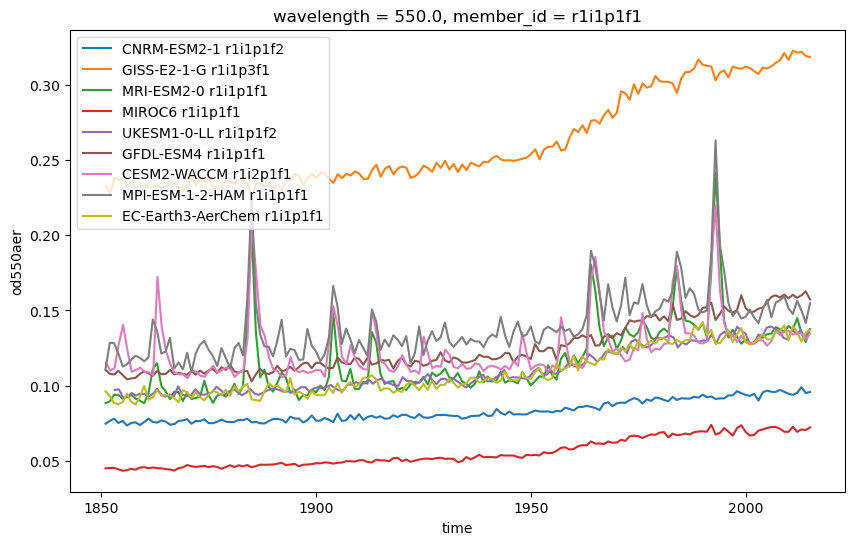

In [8]:
fig,ax = plt.subplots(figsize=(10,6))
for datakey, data in dataset_dict.items():
    source_id = data.attrs['intake_esm_attrs:source_id']
    member_id = data.attrs['intake_esm_attrs:member_id']
    data['od550aer'].isel(member_id=0).plot(label=f'{source_id} {member_id}', ax=ax)

ax.legend()
    

### Exporting a subset of the catalog

If you will only be analysing a small subset of experiments it could be easier to work with a reduced catalog. Only have a catalog containing the `histSST` and `histSST-piaer` which is one experiment with anthropogenic aerosols and without.
And only the variable the absorption optical depth (`od550abs`) and total optical depth (`od550aer`) 

In [9]:
col = intake.open_esm_datastore('/mnt/craas1-ns9989k-geo4992/data/cmip6.json') # Local data stored on NIRD



In [10]:
col = col.search(    
    experiment_id=['histSST', 'histSST-piaer'],
    variable_id = ['od550abs', 'od550aer']
)
col

,unique
variable_id,1
table_id,1
source_id,9
experiment_id,1
member_id,4
grid_label,3
time_range,185
activity_id,2
institution_id,9
version,9


Then when we are happy with the selection the catalog can be exported as follows:

In [11]:
col.serialize(name='histSST-AerChemMIP',catalog_type='file',directory='~/')

Successfully wrote ESM catalog json file to: file:///home/fc-3auid-3a9fdc0c87-2d7836-2d4bdc-2db802-2d9a250c322e3b//histSST-AerChemMIP.json


In [12]:
col = intake.open_esm_datastore('~/histSST-AerChemMIP.json')

In [13]:
col

,unique
variable_id,1
table_id,1
source_id,9
experiment_id,1
member_id,4
grid_label,3
time_range,185
activity_id,2
institution_id,9
version,9
